In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/cellar/users/mikeyu/DeepTranslate/ddot')

import numpy as np
np.set_printoptions(linewidth=150)

# Introduction: Constructing a data-driven gene ontology to study disease mechanisms

This notebook uses the DDOT Python package to create data-driven gene ontologies to study disease mechanisms. This notebook focuses on Fanconi Anemia (FA), a rare genetic disorder that is associated with bone marrow failure, myeloid dysplasia, and increased cancer risk. A total of 20 genes have been classified as FA genes because their germline mutations in patients have been associated with FA clinical phenotypes (Fanconi Anemia Mutation Database, http://www2.rockefeller.edu/fanconi/). All of these genes have known functions in the repair of DNA damage due to interstrand cross-links. However, beyond these DNA repair functions, the full spectrum of genes and pathways underlying FA remains unclear. 

To discover other genes and pathways involved in FA, here we apply DDOT in a five-step pipeline to construct a Fanconi Anemia gene ontology (FanGO) as follows (Figure A). First, we gather input data, consisting of the 20 known FA genes as a seed set of genes for modeling and a pre-computed gene similarity network derived by integrating several types of molecular evidence including protein-protein interactions, co-expression, co-localization, and epistasis. Second, we score every gene for its involvement in FA by calculating its average functional similarity to the seed genes. The minimum score among the seed genes was used as a threshold to identify an additional set of 174 candidate genes. Third, we organized all genes in a hierarchy of 74 cellular subsystems to construct FanGO. Fourth, we aligned it with GO. Finally, we uploaded FanGO to an online database, the Network Data Exchange (NDEx, http://ndexbio.org), and visualized the results in HiView (Figure B).

* Code is also provided to analyze 651 other diseases using a similar pipeline
* It is recommended that you look at the tutorial for the DDOT package at Tutorial.ipynb. 

<img src="https://github.com/michaelkyu/ontology/blob/master/docs/software_pipeline_23jan2018.png?raw=true" width="500" align="left"> 

In [2]:
import pandas as pd
import networkx as nx
import numpy as np

import ddot
from ddot import Ontology, ndex_to_sim_matrix, expand_seed, melt_square, make_seed_ontology, make_index

# Set the NDEx server and the user account/password
* Replace with your own NDEx user account

In [4]:
ndex_server = 'http://test.ndexbio.org'
ndex_user, ndex_pass = 'scratch', 'scratch'

# Specify a set of seed genes with known associations to the disease being studied

In [23]:
# Let seed genes be the 20 known genes that cause Fanconi Anemia
seed = ['FANCA', 'FANCB', 'FANCC', 'BRCA2', 'FANCD2',
        'FANCE', 'FANCF', 'FANCG', 'FANCI', 'BRIP1',
        'FANCL', 'FANCM', 'PALB2', 'RAD51C', 'SLX4',
        'ERCC4', 'RAD51', 'BRCA1', 'UBE2T', 'XRCC2']

In [24]:
# Let seed genes be the known genese for one of 651 diseases (uncomment to use)
# monarch, _ = ddot.ndex_to_sim_matrix(
#     ddot.config.MONARCH_DISEASE_GENE_SLIM_URL,
#     similarity=None,
#     input_fmt='cx',
#     output_fmt='sparse')

# Read gene-gene integrated similarity network

In [39]:
## Read gene similarity network
# sim, sim_names = ndex_to_sim_matrix(
#     ndex_uuid='d2dfa5cc-56de-11e7-a2e2-0660b7976219',
#     similarity='similarity',
#     input_fmt='cx_matrix',
#     output_fmt='matrix',
#     subset=None)

tmp = np.load('/cellar/users/mikeyu/DeepTranslate/hnexo/RFv2r3_square.npz')
rf, rf_genes = tmp['rf'], tmp['genes']
np.fill_diagonal(rf, 0)
rf[np.isnan(rf)] = 0
sim, sim_names = rf, rf_genes

sim = pd.DataFrame(sim, columns=sim_names, index=sim_names)

## Rank transform the similarities
sim_rank = sim.rank(0) / (sim.shape[0] - 1)
sim_rank = pd.DataFrame((sim_rank.values + sim_rank.values.T) / 2.0, columns=sim_names, index=sim_names)

sim_rank.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A1BG,0.000053,0.654751,0.466593,0.322811,0.027936,0.451599,0.332334,0.221617,0.565551,0.563473,...,0.470512,0.093434,0.088042,0.922059,0.198680,0.991425,0.536011,0.479693,0.021175,0.290588
A1CF,0.654751,0.000053,0.871843,0.304977,0.281618,0.465988,0.694550,0.428951,0.291614,0.970460,...,0.334991,0.475563,0.453309,0.963410,0.237216,0.781723,0.952073,0.453467,0.756576,0.301505
A2M,0.466593,0.871843,0.000053,0.999053,0.062145,0.820181,0.777252,0.430240,0.480298,0.816577,...,0.327862,0.455414,0.204230,0.495449,0.205282,0.255577,0.262837,0.731297,0.850221,0.379972
A2ML1,0.322811,0.304977,0.999053,0.000053,0.015770,0.474248,0.333386,0.476089,0.438315,0.346933,...,0.189578,0.276015,0.260390,0.968592,0.047822,0.890704,0.282092,0.447627,0.663615,0.100694
A3GALT2,0.027936,0.281618,0.062145,0.015770,0.000053,0.049229,0.009654,0.083807,0.155461,0.193261,...,0.318918,0.377512,0.259443,0.514783,0.197062,0.574311,0.825521,0.335596,0.608165,0.063526


In [38]:
# Read from local table
# gene_network_data = pd.read_table('/cellar/users/mikeyu/DeepTranslate/hnexo/fango_genes_data.txt', header=0, index_col=None)

# Download data from NDEx
from ndex.networkn import NdexGraph
G_ndex = NdexGraph(server='http://test.ndexbio.org', uuid='9412e430-02f1-11e8-bd69-0660b7976219')
G = ddot.NdexGraph_to_nx(G_ndex)
gene_network_data = ddot.nx_edges_to_pandas(G)
gene_network_data.index.names = ['Gene1', 'Gene2']
gene_network_data.reset_index(inplace=True)

gene_network_data['RF score'] = [sim.loc[g1, g2] for g1, g2 in zip(gene_network_data['Gene1'], gene_network_data['Gene2'])]

gene_network_data.head()

,Gene1,Gene2,GTEx Skin-SunExposed_Lowerleg,GTEx Esophagus-Mucosa,PPI PrePPI,PPI huMap,PPI BioGRID,GTEx Artery-Aorta,GTEx Breast-MammaryTissue,GTEx Nerve-Tibial,...,GTEx Muscle-Skeletal,GTEx sum,GTEx Adipose-Subcutaneous,PPI CCSB,GTEx Adipose-Visceral_Omentum,GTEx Esophagus-Muscularis,GTEx WholeBlood,PPI InbioMap,GTEx Heart-LeftVentricle,RF score
0,ARHGAP19,ASF1B,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,5.624597
1,ARHGAP19,C16orf59,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,4.986351
2,ARHGAP19,CCNA2,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,5.853767
3,ARHGAP19,CDC45,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,5.783103
4,ARHGAP19,CDT1,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,5.914361


# Identify candidate set of genes that are highly similar to the seed set of genes

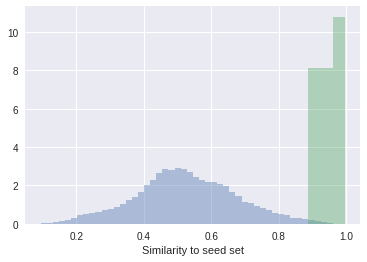

In [40]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline
# np.set_printoptions(precision=3)
# plt.rcParams['svg.fonttype'] = 'none'

expand, expand_idx, sim_2_seed, fig = expand_seed(
    seed,
    sim_rank.values,
    sim_names,
    seed_perc=0,
    agg='mean',
    figure=True)

# Organize seed and candidate genes into a data-driven gene ontology

In [27]:
# Set CliXO parameters
alpha = 0.05
beta = 0.5

# Run CliXO
ont = Ontology.run_clixo(sim.loc[expand, :].loc[:, expand], alpha, beta, square=True)
ont

194 genes, 74 terms, 349 gene-term relations, 86 term-term relations
node_attributes: []
edge_attributes: ['CLIXO_score']

# Align the data-driven ontology with the Gene Ontology (GO)

In [41]:
# Read Gene Ontology from NDEx. This version has been pre-processed to contain a non-redundant set of GO terms and connections that are relevant to human genes (see Get_Gene_Ontology.ipynb) 
go_human = Ontology.from_ndex(ddot.config.GO_HUMAN_URL)
print(go_human)

# Align ontologies
alignment = ont.align(go_human, 
                      iterations=100,
                      threads=40,
                      update_self=['Term_Description', 'Size'],
                      align_label='Term_Description',
                      verbose=True)
alignment.head()


18993 genes, 19343 terms, 215371 gene-term relations, 36362 term-term relations
node_attributes: [u'NodeType', 'name', u'isRoot', u'Branch', u'Vis:Shape', u'Label', u'Vis:Border Paint', u'Vis:Size', u'Term_Description', u'Vis:Fill Color', u'Size']
edge_attributes: [u'Is_Tree_Edge', u'Vis:Visible', u'EdgeType']
Common genes: 193
collapse command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/alignOntology/collapseRedundantNodes /tmp/tmpToyL0F
collapse command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/alignOntology/collapseRedundantNodes /tmp/tmpUmkd5D
ont1_collapsed: 193 genes, 74 terms, 348 gene-term relations, 86 term-term relations
node_attributes: ['Aligned_Term', 'Aligned_Similarity', 'Aligned_FDR', u'Aligned_Term_Description', u'Aligned_Size', 'Label', 'Vis:Fill Color']
edge_attributes: ['CLIXO_score']
ont2_collapsed: 193 genes, 1854 terms, 3594 gene-term relations, 4490 term-term relations
node_attributes: [u'NodeType', 'name', u'isRoot', u'Branch', u'Vis:Shape', u'Label', u'

,Term,Similarity,FDR
Term,,,
CLIXO:196,GO:0035098,0.902151,0.0100
CLIXO:219,GO:1905773,0.900885,0.0050
CLIXO:206,GO:1901673,0.891946,0.0100
CLIXO:205,GO:0004748,0.891813,0.0075
CLIXO:240,GO:0071821,0.891387,0.0000


# Upload ontology with NDEx to visualize in the HiView application (http://hiview.ucsd.edu)
* A two-dimensional layout of nodes is automatically calculated to optimize visualization of hierarchical structure
* Molecular networks, such as protein-protein interactions and RNA coexpression, can be visualized in HiView to understand how an ontology's structure is consistent with data
* Node attributes (color and size) can be set to visualize metadata.

In [ ]:
# Set the node color of seed genes to be green
fill_attr = pd.DataFrame({'Vis:Fill Color' : '#6ACC65'}, index=seed)
ont.update_node_attr(fill_attr)

In [42]:
# Download a preformatted network containing multiple types of gene-gene interactions has been preformatted and uploaded into NDEx for the Fanconi Anemia example.
from ndex.networkn import NdexGraph
G_ndex = NdexGraph(server='http://test.ndexbio.org', uuid='9412e430-02f1-11e8-bd69-0660b7976219')
G = ddot.NdexGraph_to_nx(G_ndex)
gene_network_data = ddot.nx_edges_to_pandas(G)
gene_network_data.index.names = ['Gene1', 'Gene2']
gene_network_data.reset_index(inplace=True)
# gene_network_data = pd.read_table('/cellar/users/mikeyu/DeepTranslate/hnexo/fango_genes_data.txt', header=0, index_col=None)
gene_network_data['RandomForest integrated similarity'] = [sim.loc[g1, g2] for g1, g2 in zip(gene_network_data['Gene1'], gene_network_data['Gene2'])]
gene_network_data.head()

,Gene1,Gene2,GTEx Skin-SunExposed_Lowerleg,GTEx Esophagus-Mucosa,PPI PrePPI,PPI huMap,PPI BioGRID,GTEx Artery-Aorta,GTEx Breast-MammaryTissue,GTEx Nerve-Tibial,...,GTEx Muscle-Skeletal,GTEx sum,GTEx Adipose-Subcutaneous,PPI CCSB,GTEx Adipose-Visceral_Omentum,GTEx Esophagus-Muscularis,GTEx WholeBlood,PPI InbioMap,GTEx Heart-LeftVentricle,RandomForest integrated similarity
0,ARHGAP19,ASF1B,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,5.624597
1,ARHGAP19,C16orf59,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,4.986351
2,ARHGAP19,CCNA2,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,5.853767
3,ARHGAP19,CDC45,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,5.783103
4,ARHGAP19,CDT1,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,5.914361


In [45]:
# Upload ontology to NDEx
ndex_url, _ = ont.to_ndex(
            name='Fanconi Anemia Gene Ontology',
            ndex_server=ndex_server,
            ndex_user=ndex_user,
            ndex_pass=ndex_pass,
            visibility='PUBLIC',
            layout='bubble-collect',
            network=gene_network_data,
            main_feature='RandomForest integrated similarity')
print('Go to http://hiview.ucsd.edu in your web browser')
print('Enter this into the "NDEx Sever URL" field: %s' % ndex_url.split('ndexbio.org')[0] + 'ndexbio.org')
print('Enter this into the "UUID of the main hierarchy" field: %s' % ndex_url.split('/')[-1])


Go to http://hiview.ucsd.edu in your web browser
Enter this into the "NDEx Sever URL" field: http://dev2.ndexbio.org
Enter this into the "UUID of the main hierarchy" field: b20bb038-5d2a-11e8-9d1c-0660b7976219


In [46]:
print(ndex_url)

http://dev2.ndexbio.org/v2/network/b20bb038-5d2a-11e8-9d1c-0660b7976219


## Alternative code for the above steps using the convience function `make_seed_ontology`

In [ ]:
ont, url, ont_ndexgraph, expand_results = make_seed_ontology(
      sim,
      sim_names,
      build_kwargs={'alpha' : alpha,
                    'beta' : beta,
                    'method' : 'clixo'},
      expand_kwargs={'seed' : seed,
                     'sim': sim_rank.values,
                     'sim_names': sim_names,
                     'seed_perc':0,
                     'agg':'mean',
                     'figure':True},
      align_kwargs={'hier' : go_human,
                    'iterations':100,
                    'threads': 40,
                    'update_self': ['Term_Description', 'Size'],
                    'align_label' : 'Term_Description'},
      ndex_kwargs={'ndex_user':ndex_user,
                   'ndex_pass':ndex_pass,
                   'ndex_server':ndex_server,
                   'name' : 'Fanconi Anemia Gene Ontology (FanGO)',
                   'visible_term_attr': ['Aligned_Term',
                                         'Aligned_Similarity',
                                         'Aligned_FDR',
                                         'Aligned_Term_Description',
                                         'Aligned_Size',
                                         'Similarity_2_Seed'],
                   'subnet_max_term_size' : 0,
                   'visibility' : 'PUBLIC',
                   'layout' : 'bubble-collect',                  
                   'network' : hnexo_data,
                   'features' : hnexo_data.columns,
                   'main_feature' : 'RF score'},
      node_attr=gene_drug,
      verbose=False,
      ndex=True,
)
print(url)
print(ont)